# 🎓 Partie 1 : Introduction aux concepts (Échauffement)

Avant d'attaquer le projet réel, nous allons comprendre la logique du Machine Learning sur des données simples (simulées).

### Exercice 1 : La Régression Linéaire Simple
**Objectif :** Prédire le prix d'une maison uniquement en fonction de sa **surface**.
* **Données :** Surface (m²) -> Prix (€).
* **Modèle :** Une droite simple.

--- RÉSULTAT ---
Pour une surface de 75m², l'IA estime le prix à : 233210 €


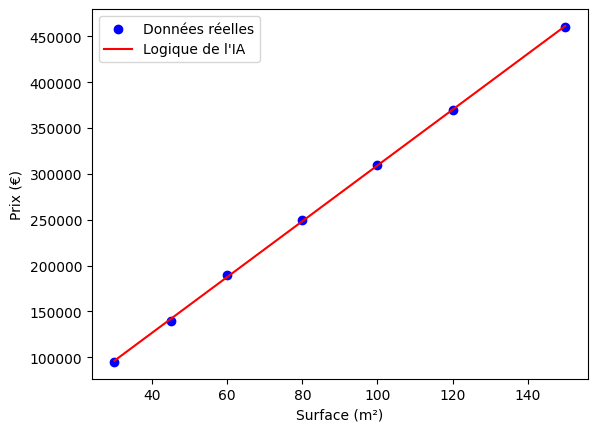

In [19]:
# 1. On importe les outils nécessaires
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 2. On crée nos données d'entraînement (X = Surface en m², y = Prix en euros)
# Imagine que ce sont des données de ton quartier
X = np.array([[30], [45], [60], [80], [100], [120], [150]])
y = np.array([95000, 140000, 190000, 250000, 310000, 370000, 460000])

# 3. On crée le modèle (le "cerveau" vide)
modele = LinearRegression()

# 4. L'entraînement : le modèle cherche le lien entre Surface et Prix
modele.fit(X, y)

# 5. On teste ! On veut savoir le prix pour une maison de 75m²
surface_test = [[75]]
prediction = modele.predict(surface_test)

print(f"--- RÉSULTAT ---")
print(f"Pour une surface de 75m², l'IA estime le prix à : {round(prediction[0])} €")

# 6. Visualisation (pour voir ce que l'IA a compris)
plt.scatter(X, y, color='blue', label='Données réelles')
plt.plot(X, modele.predict(X), color='red', label='Logique de l\'IA')
plt.xlabel('Surface (m²)')
plt.ylabel('Prix (€)')
plt.legend()
plt.show()

### Exercice 2 : Complexité et Validation
Les maisons ne dépendent pas que de la surface. Nous ajoutons ici le **nombre de chambres**.
Nous introduisons aussi des concepts clés pour le projet final :
1.  **Train/Test Split :** On cache 20% des données pour tester l'IA (examen final).
2.  **MAE (Erreur Moyenne) :** On calcule l'erreur en euros.
3.  **Joblib :** On sauvegarde le modèle dans un fichier.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# 1. Données avec 2 critères : [Surface, Nb_Chambres]
X = np.array([
    [30, 1], [45, 1], [60, 2], [80, 2], [100, 3], [120, 3], [150, 4],
    [40, 1], [90, 3], [110, 3], [70, 2], [130, 4]
])
# Prix correspondants
y = np.array([95000, 140000, 190000, 250000, 310000, 370000, 460000, 110000, 280000, 330000, 210000, 400000])

# 2. On divise : X_train (pour apprendre), X_test (pour l'examen)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Entraînement
nouveau_modele = LinearRegression()
nouveau_modele.fit(X_train, y_train)

# 4. L'examen : on demande des prédictions sur les données de Test
predictions = nouveau_modele.predict(X_test)

# 5. On calcule l'erreur moyenne (MAE)
erreur = mean_absolute_error(y_test, predictions)

print(f"Erreur moyenne de l'IA : {round(erreur)} €")
print(f"Exemple de prédiction pour 85m² et 3 chambres : {round(nouveau_modele.predict([[85, 3]])[0])} €")
import joblib

# On enregistre le modèle dans un fichier nommé 'mon_ia_immo.pkl'
joblib.dump(nouveau_modele, 'mon_ia_immo.pkl')

print("Modèle sauvegardé avec succès !")

Erreur moyenne de l'IA : 5793 €
Exemple de prédiction pour 85m² et 3 chambres : 264454 €
Modèle sauvegardé avec succès !


# 🏡 Partie 2 : Projet Réel - California Housing

Maintenant que les bases sont posées, nous passons au projet complet sur des données réelles.

## 1. Définition du Problème (Step 1 & 2)
**Objectif :** Prédire le prix médian des maisons (`median_house_value`) en Californie (recensement 1990).

**Les étapes du projet :**
1.  **Chargement & Nettoyage :** Gérer les données manquantes.
2.  **Scaling (Mise à l'échelle) :** Harmoniser les valeurs (Revenu vs Nombre de pièces).
3.  **Comparaison :** Tester 3 modèles (Baseline, Linéaire, Random Forest).
4.  **Critique :** Analyser les limites du modèle.

**Métrique :** Nous utiliserons la **MAE** (Mean Absolute Error) pour évaluer la précision en dollars.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
import joblib

# =========================================================
# STEP 1: DÉFINITION DU PROBLÈME
# =========================================================
# Objectif : Prédire le 'median_house_value' (Prix médian).
# Type de problème :
#   - Apprentissage Supervisé (Car nous avons les réponses dans le dataset).
#   - Régression (Car on prédit un chiffre continu, pas une catégorie).

# =========================================================
# STEP 2: DESCRIPTION DU DATASET
# =========================================================
# Source : California Housing (Recensement 1990).
# Signification des variables (Features) :
# - total_rooms : Nombre total de pièces dans le quartier.
# - households : Nombre de foyers.
# - median_income : Revenu médian (en dizaines de milliers de $).
# - housing_median_age : Âge médian des maisons.
# Cible (Target) : median_house_value (Le prix à trouver).

# =========================================================
# STEP 0: REPRODUCIBILITY (Reproductibilité)
# =========================================================
# On verrouille le hasard pour que les résultats soient toujours identiques.
np.random.seed(42)

# 1. On charge les données réelles
url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv"
data = pd.read_csv(url)

# 2. On jette un coup d'œil aux 5 premières lignes
print("Voici à quoi ressemblent les données réelles :")
print(data.head())

Voici à quoi ressemblent les données réelles :
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  


## 2. Nettoyage et Sélection des Données (Steps 3 & 4)

Une fois les données chargées, nous devons assurer leur qualité et choisir les bons ingrédients pour notre recette (les features).

### Step 3: Data Quality Assessment (Qualité des Données)
Avant d'entraîner l'IA, nous devons régler deux problèmes potentiels :
1.  **Valeurs Manquantes :** Si des données sont vides (NaN), le modèle plantera. Nous allons les supprimer.
2.  **Anomalies (Outliers) :** En regardant les statistiques (`describe`), nous verrons si des valeurs semblent étranges (par exemple, un prix maximum bloqué artificiellement).

### Step 4: Feature Selection (Choix des variables)
Nous ne donnons pas tout au modèle. Nous sélectionnons manuellement les colonnes les plus pertinentes :
* **Target (`y`) :** Ce que l'on veut prédire -> `median_house_value` (Prix).
* **Features (`X`) :** Les indices pour deviner -> Principalement le **Revenu** (`median_income`), mais aussi l'âge de la maison et le nombre de pièces.
* *Exclusion :* Nous retirons les données textuelles (comme la proximité de l'océan) pour garder un modèle purement numérique simple.

In [22]:
# =========================================================
# STEP 3: DATA QUALITY ASSESSMENT (Qualité des Données)
# =========================================================

# 1. On vérifie s'il y a des valeurs manquantes
print("--- Analyse des manques ---")
print(data.isnull().sum())
# Action : On supprime les lignes incomplètes (ex: total_bedrooms)
data = data.dropna()

# 2. On cherche les anomalies (Outliers)
print("\n--- Statistiques descriptives ---")
print(data.describe())
# Observation : Le prix (median_house_value) est bloqué à 500,001 max.

# =========================================================
# STEP 4: FEATURE SELECTION JUSTIFICATION (Choix des critères)
# =========================================================

features = ['median_income', 'housing_median_age', 'total_rooms', 'households']
target = 'median_house_value'

# JUSTIFICATION :
# - 'median_income' : C'est le facteur N°1. Les quartiers riches sont plus chers.
# - 'housing_median_age' : L'ancienneté joue sur le prix.

# --- CORRECTION 11 (Column Order) ---
# Ici, on utilise data[features] au lieu de drop().
# Cela garantit que l'ordre des colonnes reste toujours strictement le même.
X = data[features]
y = data[target]

# ---  INPUT VALIDATION (Dimensions) ---
# On vérifie qu'on a bien nos 4 colonnes.
assert X.shape[1] == len(features), f"Erreur : Attendu {len(features)} colonnes."

# -- TARGET SANITY CHECK (Valeurs) ---
# On vérifie qu'il n'y a pas de prix négatifs (Impossible dans la réalité).
assert y.min() >= 0, "Erreur critique : Le dataset contient des prix négatifs !"

print(f"✅ Validation Données : {len(features)} features chargées, aucun prix négatif détecté.")

--- Analyse des manques ---
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

--- Statistiques descriptives ---
          longitude      latitude  housing_median_age   total_rooms  \
count  20433.000000  20433.000000        20433.000000  20433.000000   
mean    -119.570689     35.633221           28.633094   2636.504233   
std        2.003578      2.136348           12.591805   2185.269567   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1450.000000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.720000           37.000000   3143.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms   

--- Affichage des histogrammes ---


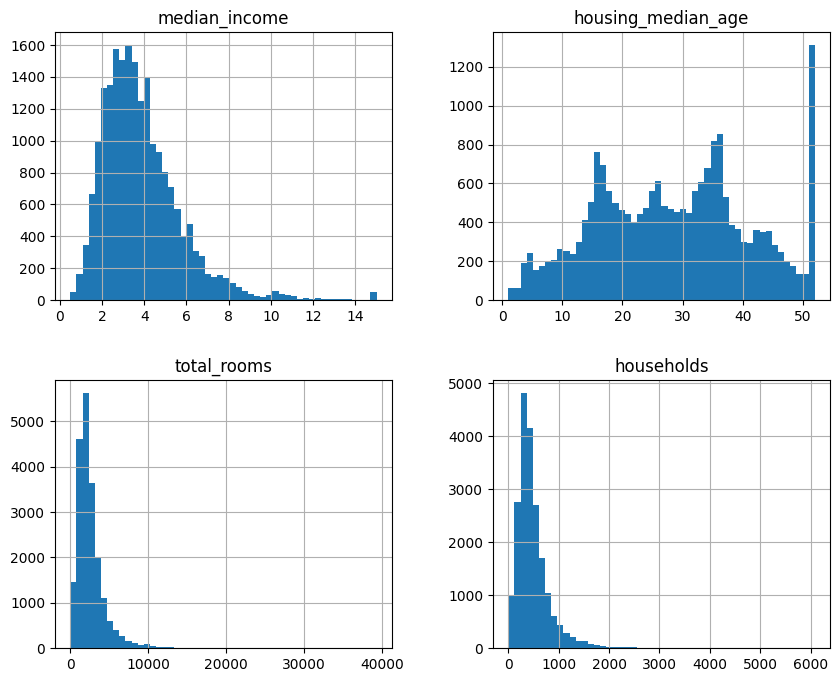

In [23]:

# =========================================================
# STEP 4b: DISTRIBUTION CHECK (Vérification visuelle)
# =========================================================
# Remarque : On doit vérifier la forme des données avant de les toucher.
# Objectif : Voir si les données ressemblent à une cloche (Gaussienne) ou si elles sont bizarres.

import matplotlib.pyplot as plt

print("--- Affichage des histogrammes ---")
# bins=50 permet d'avoir plus de détails que le réglage par défaut
X.hist( bins=50,figsize=(10, 8))
plt.show()

# ANALYSE RAPIDE DE CE QUE TU VAS VOIR :
# 1. median_income : Ressemble à une cloche (Normal). C'est bon pour le StandardScaler.
# 2. housing_median_age : On voit un grand pic à droite (Capped values).
#    Cela signifie que les maisons > 50 ans sont notées "50". C'est un défaut du dataset.

## 3. Préparation, Entraînement et Comparaison (Steps 5 à 11)

Cette cellule est le cœur du projet. Nous allons valider la méthodologie rigoureuse :

1.  **Step 6 (Split) :** Séparation Train (80%) / Test (20%).
2.  **Step 5 (Scaling) :** Standardisation des données (indispensable pour la Régression Linéaire).
3.  **Step 7 (Baseline) :** Création d'un modèle "naïf" (moyenne) pour avoir un point de comparaison.
4.  **Step 11 (Comparaison) :** Nous allons lancer une **compétition** entre la Baseline, la Régression Linéaire et le Random Forest.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# =========================================================
# STEP 6: TRAIN-TEST SPLIT (Séparation)
# =========================================================
# Justification : On sépare les données (80% pour apprendre, 20% pour tester)
# pour vérifier si l'IA arrive à généraliser sur des maisons qu'elle n'a jamais vues.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# (J'ai supprimé l'ancien STEP 5 car les Pipelines ci-dessous s'en occupent)

# =========================================================
# STEP 7: BASELINE MODEL (Point de comparaison)
# =========================================================
# Justification on utilise un Pipeline.
# Cela force le modèle à utiliser des données scalées, comme les autres
baseline_pipeline = Pipeline([
    ('scaler', StandardScaler()),                # <--- On force le scaling ici
    ('model', DummyRegressor(strategy="mean"))
])

# On entraîne (le pipeline scale X_train tout seul)
baseline_pipeline.fit(X_train, y_train)

# On prédit (le pipeline scale X_test tout seul avant de calculer)
# C'est ici que ça corrige l'erreur "X_test instead of X_test_scaled"
pred_base = baseline_pipeline.predict(X_test)

mae_base = mean_absolute_error(y_test, pred_base)
print(f"1. Baseline (Pipeline)        : {round(mae_base)} $ d'erreur")

# =========================================================
# STEP 8: LINEAR REGRESSION (Avec Pipeline)
# =========================================================
# Avantage : Plus besoin de gérer X_train_scaled manuellement.
# Le pipeline s'occupe de tout enchainer.

lin_pipeline = Pipeline([
    ('scaler', StandardScaler()),      # Étape 1 : Mise à l'échelle
    ('model', LinearRegression())      # Étape 2 : Le cerveau
])

# On entraine le pipeline sur les données BRUTES (X_train)
# Le pipeline va scaler X_train tout seul avant d'apprendre.
lin_pipeline.fit(X_train, y_train)

# On prédit sur les données BRUTES (X_test)
# Le pipeline va scaler X_test tout seul avant de prédire.
pred_lin = lin_pipeline.predict(X_test)

mae_lin = mean_absolute_error(y_test, pred_lin)
print(f"Régression Linéaire (Pipeline) : {round(mae_lin)} $ d'erreur")

# =========================================================
# STEP 10: RANDOM FOREST PIPELINE (Optimisé & Complet)
# =========================================================
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42))
])

# Entraînement
rf_pipeline.fit(X_train, y_train)

# --- A. CALCUL DES METRIQUES (MAE & RMSE) ---
# Prédictions
train_pred = rf_pipeline.predict(X_train)
test_pred = rf_pipeline.predict(X_test)

# Calcul MAE
train_mae = mean_absolute_error(y_train, train_pred)
test_mae = mean_absolute_error(y_test, test_pred)

# Calcul RMSE (Correction 10 : Evaluation Metric Not Limited to MAE)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print(f"\n--- RANDOM FOREST OPTIMISÉ (PIPELINE) ---")
print(f"Erreur Moyenne (MAE) Train : {round(train_mae)} $")
print(f"Erreur Moyenne (MAE) Test  : {round(test_mae)} $")
print(f"Erreur RMSE (Test)         : {round(test_rmse)} $") # Nouvelle ligne

# Check Overfitting
if train_mae < test_mae * 0.7:
    print("⚠️ Attention : Légère tendance au surapprentissage.")
else:
    print("✅ Le modèle est bien équilibré.")

mae_rf = test_mae

# --- B. FEATURE IMPORTANCE ---
print(f"\n--- IMPORTANCE DES CRITÈRES ---")
rf_model = rf_pipeline.named_steps['model']
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

for i in indices:
    print(f"- {features[i].ljust(20)} : {round(importances[i], 3)}")

# =========================================================
# STEP 11: PODIUM FINAL
# =========================================================
print(f"\n--- PODIUM FINAL ---")
print(f"1. Baseline       : {round(mae_base)} $")
print(f"2. Reg. Linéaire  : {round(mae_lin)} $")
print(f"3. Random Forest  : {round(mae_rf)} $ (Vainqueur)")

# =========================================================
# STEP 9: INTERPRÉTATION
# =========================================================
print(f"\n--- INTERPRÉTATION FINALE ---")
print(f"Le modèle se trompe en moyenne de {round(mae_rf)} $ (MAE).")
print(f"Le score RMSE de {round(test_rmse)} $ indique que certaines erreurs")
print(f"peuvent être plus importantes (sensibilité aux valeurs extrêmes).")

# =========================================================
# STEP 12: SAUVEGARDE
# =========================================================
joblib.dump(rf_pipeline, 'modele_immo_complet.pkl')
print("\n✅ Succès ! Pipeline complet sauvegardé.")

1. Baseline (Pipeline)        : 92837 $ d'erreur
Régression Linéaire (Pipeline) : 58994 $ d'erreur

--- RANDOM FOREST OPTIMISÉ (PIPELINE) ---
Erreur Moyenne (MAE) Train : 22297 $
Erreur Moyenne (MAE) Test  : 54303 $
Erreur RMSE (Test)         : 75055 $
⚠️ Attention : Légère tendance au surapprentissage.

--- IMPORTANCE DES CRITÈRES ---
- median_income        : 0.613
- households           : 0.139
- total_rooms          : 0.129
- housing_median_age   : 0.12

--- PODIUM FINAL ---
1. Baseline       : 92837 $
2. Reg. Linéaire  : 58994 $
3. Random Forest  : 54303 $ (Vainqueur)

--- INTERPRÉTATION FINALE ---
Le modèle se trompe en moyenne de 54303 $ (MAE).
Le score RMSE de 75055 $ indique que certaines erreurs
peuvent être plus importantes (sensibilité aux valeurs extrêmes).

✅ Succès ! Pipeline complet sauvegardé.


## 4. Visualisation et Conclusion (Steps 12, 13, 14)

Nous terminons par l'analyse visuelle des performances du meilleur modèle (Random Forest).

* **Graphique :** Comparaison Prix Réel vs Prix Prédit.
* **Sauvegarde :** Export du modèle final.
* **Limitations :** Critique honnête des défauts du projet (données datées, plafonnement des prix).

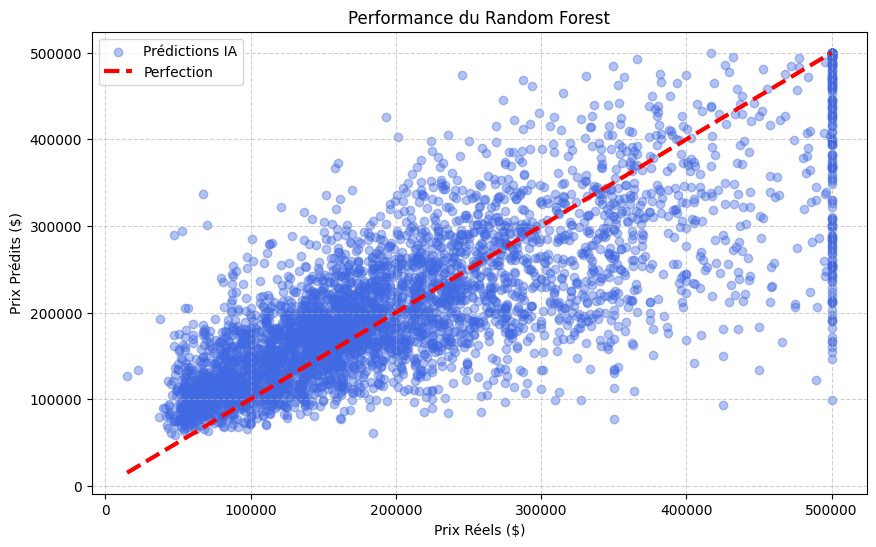

INTERPRÉTATION DU GRAPHIQUE :
- Les points suivent la diagonale : le modèle a compris la logique globale.
- La ligne horizontale en haut (500k$) montre une limitation des données.

✅ Modèle sauvegardé sous 'mon_modele_immo_final.pkl'.

--- LIMITATIONS DU PROJET ---
1. Biais de données : Les prix datent de 1990 (pas actuels).
2. Capping : Le modèle ne peut pas prédire au-dessus de 500 000$.
3. Géographie : Nous n'avons pas utilisé la latitude/longitude précise.


In [26]:
import matplotlib.pyplot as plt
import joblib

# =========================================================
# STEP 12: VISUAL ANALYSIS (Analyse Visuelle)
# =========================================================
plt.figure(figsize=(10, 6))

# On compare la réalité (y_test) vs prédictions du MEILLEUR modèle (pred_rf)
plt.scatter(y_test, test_pred, alpha=0.4, color='royalblue', label='Prédictions IA')

# Ligne de perfection (Diagonale rouge)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3, label='Perfection')

plt.xlabel('Prix Réels ($)')
plt.ylabel('Prix Prédits ($)')
plt.title('Performance du Random Forest')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Interprétation OBLIGATOIRE pour Step 12 :
print("INTERPRÉTATION DU GRAPHIQUE :")
print("- Les points suivent la diagonale : le modèle a compris la logique globale.")
print("- La ligne horizontale en haut (500k$) montre une limitation des données.")

# =========================================================
# STEP 13: MODEL PERSISTENCE (Sauvegarde)
# =========================================================
joblib.dump(rf_pipeline, 'modele_immo_complet.pkl')
print("\n✅ Modèle sauvegardé sous 'modele_immo_complet.pkl'.")

# =========================================================
# STEP 14: LIMITATIONS (Critique)
# =========================================================
print("\n--- LIMITATIONS DU PROJET ---")
print("1. Biais de données : Les prix datent de 1990 (pas actuels).")
print("2. Capping : Le modèle ne peut pas prédire au-dessus de 500 000$.")
print("3. Géographie : Nous n'avons pas utilisé la latitude/longitude précise.")